# Fermi LAT
## Context
Due to previous mixed results an in-depth study focused on the Crab pulsar (PSR B0531+21/J0534+2200, about 10 km radius, 1.4 M⊙ and ~33 tr/s) with the Fermi Gamma-ray space telescope. Composed of two parts :
- 1 lawer of crossed silicon line in order to detect the position and the angle of the incomming gamma (and some energy)
- 1 lawer of plastic scintillator to mesure essetially the deposed energy (the gamma pass through it))
it observe continuously 20% of the sky and can intercept approximatively 1 photo over 1e14 rotation of the Crab pulsar.
This notebook records all the process and results of the construction and the theoritical confrontation of the SED of the Crab pulsar in a field of observation about 5°.

## Problem

The previous study of the spectral energy density of the Crab pulsar (J0534+2200) show an unpredicted diviation from the expected values in high energies, but no conclusion was made due to the lack of datas. The main goal of this study is so to conclude definitly on the shape of the SED and discuss about the respect of the theory and a possible second component in high energies.

## Process
1. Using the Fermi plugin of Tempo2, each photon registred in the .fits file is associated to a rotation phase due to the .par file containing the corresponding ephemerides (columns barytime and "PULSE_PHASE")
1. Using the "Data preparation" section the off pulse interval is extracted from the .fits files (photon and space craft)
1. Using "ROI preparation" section the .xml listing all sources in a field of 20° around the pulsar is preapared for the new source modeling
1. Using gtselect the off-pulse and on-pulse photons are extracted in order to perform the source modeling 
1. Using "Data processing" section the .fits files are cleaned and the SED is made

## Analysis
This section describe the SED analize

# Data preparation
1. Get the ephemerides .par file betwen (54686.1526259, and 58123.1616338) see [MJD time converter](https://heasarc.gsfc.nasa.gov/cgi-bin/Tools/xTime/xTime.pl)
1. Get fits files (photon and spacecraft) of the period [datas](../datas/Crabe_1/)

In [ ]:
%%bash
conda activate fermi
cd /data

: 

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import helpers.fits as hf
import helpers.roi as hr
from scipy import integrate

In [8]:
# hdus = hf.get_hdus("../datas/Crabe_1")
hdus = hf.get_hdus("Crabe_1")
pulses = hf.extend(hf.merge('PULSE_PHASE', hdus))

In [9]:
print(hdus[0][1].data.columns)

ColDefs(
    name = 'ENERGY'; format = 'E'; unit = 'MeV'
    name = 'RA'; format = 'E'; unit = 'deg'
    name = 'DEC'; format = 'E'; unit = 'deg'
    name = 'L'; format = 'E'; unit = 'deg'
    name = 'B'; format = 'E'; unit = 'deg'
    name = 'THETA'; format = 'E'; unit = 'deg'
    name = 'PHI'; format = 'E'; unit = 'deg'
    name = 'ZENITH_ANGLE'; format = 'E'; unit = 'deg'
    name = 'EARTH_AZIMUTH_ANGLE'; format = 'E'; unit = 'deg'
    name = 'TIME'; format = 'D'; unit = 's'
    name = 'EVENT_ID'; format = 'J'
    name = 'RUN_ID'; format = 'J'
    name = 'RECON_VERSION'; format = 'I'
    name = 'CALIB_VERSION'; format = '3I'
    name = 'EVENT_CLASS'; format = '32X'
    name = 'EVENT_TYPE'; format = '32X'
    name = 'CONVERSION_TYPE'; format = 'I'
    name = 'LIVETIME'; format = 'D'; unit = 's'
    name = 'DIFRSP0'; format = 'E'
    name = 'DIFRSP1'; format = 'E'
    name = 'DIFRSP2'; format = 'E'
    name = 'DIFRSP3'; format = 'E'
    name = 'DIFRSP4'; format = 'E'
    name = 'PULSE

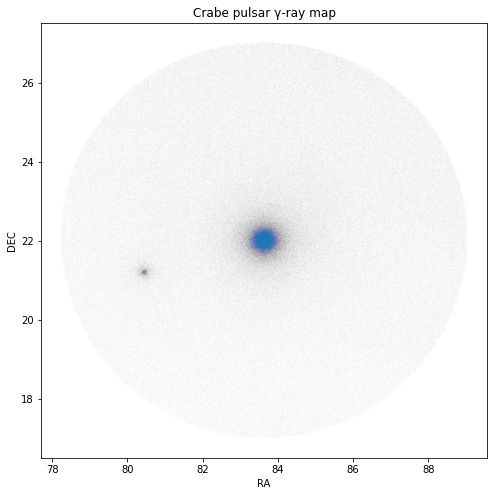

In [10]:
plt.figure(figsize=(8,8))
plt.scatter(hf.merge('RA', hdus), hf.merge('DEC', hdus), s=hf.merge('ENERGY', hdus) / 5e8)
plt.xlabel("RA")
plt.ylabel("DEC")
plt.title("Crabe pulsar γ-ray map")
plt.show()

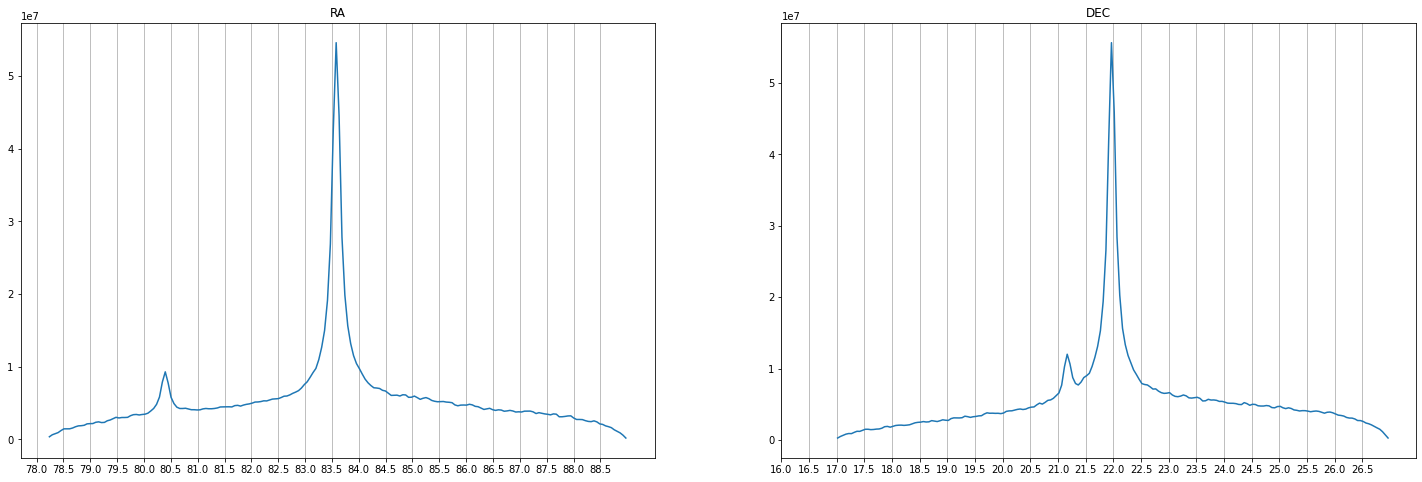

In [11]:
#get pulsar dimensions
def __tmp():
    e = hf.merge('ENERGY', hdus)
    ra = hf.merge('RA', hdus)
    dec = hf.merge('DEC', hdus)
    plt.figure(figsize=(25,8))
    plt.subplot(1, 2, 1)
    c, b = np.histogram(ra, 200, weights=e)
    d_c = np.cumsum(np.gradient(c))
    plt.plot(b[:-1], d_c)
    plt.title('RA')
    plt.grid(axis="x")
    plt.xticks(np.arange(78.0, 89.0, 0.5))
    plt.subplot(1, 2, 2)
    c, b = np.histogram(dec, 200, weights=e)
    d_c = np.cumsum(np.gradient(c))
    plt.plot(b[:-1], d_c)
    plt.title('DEC')
    plt.grid(axis="x")
    plt.xticks(np.arange(16.0, 27.0, 0.5))
    plt.show()
__tmp()

In [13]:
#get bg_energy
def __tmp(l):
    l = l * 100000
    _e = hf.merge('ENERGY', hdus)
    print(f"{100 * (l + 100000) / len(_e):.0f}% done")
    e = _e[l:l + 100000]
    ra = hf.merge('RA', hdus)[l:l + 100000]
    dec = hf.merge('DEC', hdus)[l:l + 100000]
    inter_ra_1 = [80.2, 80.6]
    inter_ra_2 = [82.5, 85.0]
    inter_dec_1 = [21.0, 21.4]
    inter_dec_2 = [21.0, 23.0]

    f_e = np.array([])
    for i in range(len(e)):
        if (not inter_ra_1[0] < ra[i] < inter_ra_1[1]) or (not inter_ra_2[0] < ra[i] < inter_ra_2[1]):
            if (not inter_dec_1[0] < dec[i] < inter_dec_1[1]) or (not inter_dec_2[0] < dec[i] < inter_dec_2[1]):
                f_e = np.append(f_e, e[i])

    return (np.mean(f_e), np.std(f_e))       

def __tmp2():
    m = np.array([])
    s = np.array([])
    e = hf.merge('ENERGY', hdus)
    for i in range(0, int(len(e) / 100000)):
        (_m, _s) = __tmp(i)
        m = np.append(m, _m)
        s = np.append(s, _s)
    return (np.mean(m), np.sqrt(np.sum(np.square(s))))
print(__tmp2())

6% done
11% done
17% done
23% done
29% done
34% done
40% done
46% done
51% done
57% done
63% done
69% done
74% done
80% done
86% done
91% done
97% done
(658.4109839972848, 11205.016197013916)


3. Process with Tempo2 fits to make the barycentrization
3. Determine and correct the phasogramm using [fits with astropy](https://astropy4cambridge.readthedocs.io/en/latest/_static/Astropy%20-%20Handling%20FITS%20files.html)

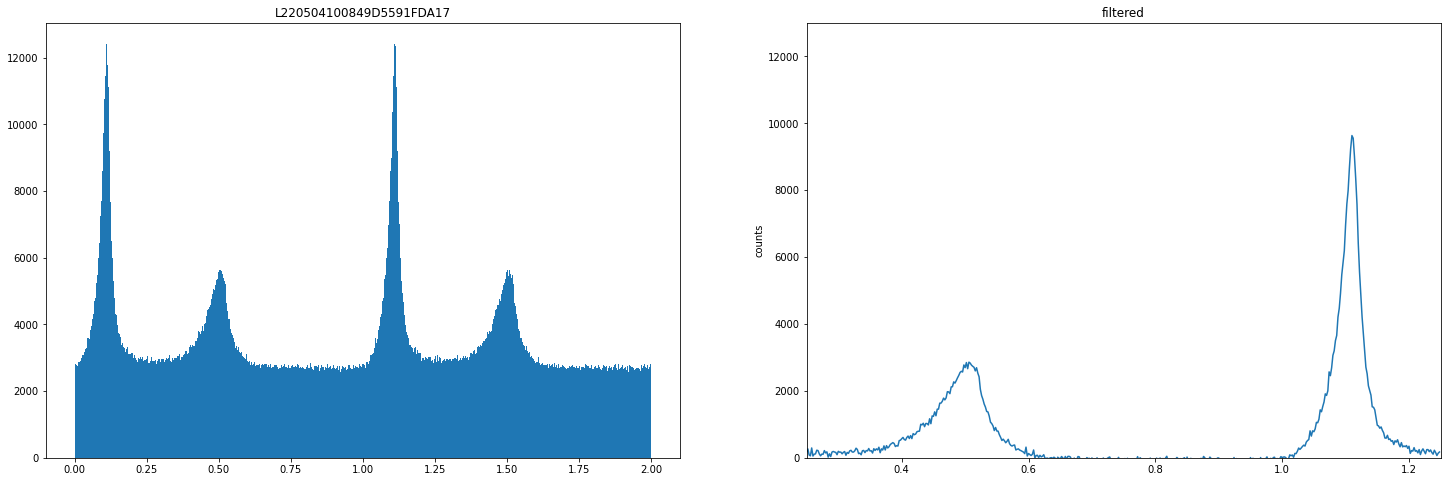

In [32]:
resolution = 1000
plt.figure(figsize=(25,8))
plt.subplot(1, 2, 1)
counts, bins, bars = plt.hist(pulses, bins = resolution, label="counts")
plt.title(hdus[0][0].header['FILENAME'].split('_')[0])

filtered = hf.filter_background(counts, 100)
plt.subplot(1, 2, 2)
disp_range = [int(0.5 * resolution * 0.25), int(0.5 * resolution * 1.25)]
(phase_bins, phase_counts) = bins[disp_range[0]:disp_range[1]], filtered[disp_range[0]:disp_range[1]]
plt.plot(phase_bins, phase_counts)
plt.axis([0.25, 1.25, 0, 13000])
plt.title('filtered')
plt.ylabel("counts")

plt.show()

In [ ]:
integrale_counts = integrate.cumtrapz(phase_counts, phase_bins)
bg_efficiency = (integrale_counts[-1] - integrale_counts[0])/(np.trapz(counts[disp_range[0]:disp_range[1]], bins[disp_range[0]:disp_range[1]]))
print(f"Background efficiency = {(bg_efficiency * 100):.2f}%")
plt.plot(phase_bins[:-1], integrale_counts)
(inter_x, inter_y) = hf.get_inter(phase_bins[:-1], integrale_counts)
plt.plot(inter_x, inter_y)
plt.show()

In [ ]:
energy = hf.extend(hf.merge('ENERGY', hdus))

int_hist (fltrer bg) => filtered hist => filtered Phase => filtered E => dN/dE

In [ ]:
# corrected_pulses = np.array([])
# corrected_energy = np.array([]) 
# for s in range(0,3000000,100000):
#     (_p, _e) = hf.filter_energy(pulses[s:s + 100000], energy[s:s + 100000], inter_x)
#     corrected_pulses = np.append(corrected_pulses, _p)
#     corrected_energy = np.append(corrected_energy, _e * bg_efficiency)

In [ ]:
print(inter_x)

In [ ]:
(corrected_pulses, corrected_energy) = hf.get_efficiency(hdus, pulses, inter_x, bg_efficiency)

In [ ]:
for s in range(0,3000000,100000):
    plt.scatter(pulses[s:s + 100000], energy[s:s + 100000], 0.1, c="#e377c2")
for s in range(0,3000000,100000):
    plt.scatter(corrected_pulses[s:s + 100000], corrected_energy[s:s + 100000], 0.1, c="#1f77b4")
plt.ylabel('Energy (MeV)')
plt.xlabel('Phase')
plt.title('Energy phasogramm')
plt.show()

In [ ]:
for s in range(0,3000000,100000):
    plt.scatter(*hf.spectrum(corrected_energy[s:s + 100000], corrected_pulses[s:s + 100000]), 0.1, c="#1f77b4")
plt.axis([-.002, .002, 0, 70000])
plt.ylabel('dN/dE')
plt.xlabel('E')
plt.show()

- phase_interval: 0.007999279022217, 0.6239995536804199
- emax: 285086.28125
- RA: 82.5, 85.0 => mean: 83.75 => rad: 1.25
- DEC: 21, 23 => mean: 22 => rad: 1
- Energy (mean, std): 658.4026612922821, 11203.135894624394
- Time range (MET): 239859588, 536817170

## Events processing

### Tutorials end examples
- [analysis thread](https://fermi.gsfc.nasa.gov/ssc/data/analysis/scitools/)
- [use of the analysis thread](https://fermi.gsfc.nasa.gov/ssc/data/analysis/documentation/Cicerone/Cicerone_Thread_Use/)
- [data preparation](https://fermi.gsfc.nasa.gov/ssc/data/analysis/scitools/data_preparation.html)
- [Fermi analysis video tutorial](https://fermi.gsfc.nasa.gov/ssc/data/analysis/video_tutorials/)
- [binned likehood tutorial](https://fermi.gsfc.nasa.gov/ssc/data/analysis/scitools/binned_likelihood_tutorial.html)
- [bash example](https://github.com/fermi-lat/AnalysisThreads/blob/master/GRBAnalysis/1.LATGRBAnalysis/1.LATGRBAnalysis.ipynb)
- [python example](https://github.com/fermi-lat/sane/blob/24deb3cb5daf5b148268d2d463fd002d8edde71f/python/tests/BinnedLikelihood_test.py)

Shell tools process
![Shell tools process](./assets/shell_tools_diagram.png)

1. Remove nebuleuse effect : Get bg w/ gtselect => filter event w/ gtmktime => construct model w/ gtltcube => remove crabe sources from xml => get model w/ gtlike
2. Get pulsar w/ gtselect => filter event w/ gtmktime => construct model w/ gtltcude => get model w/ gtlike

In [ ]:
%%bash
proc=$(nproc --all)
cores=$(($proc - 4)) #leaving 4 cores to user
sc="L220504100849D5591FDA17_SC00.fits" #spacecraft fits file
MET_START=239859588 #MET time range
MET_END=536817170 #MET time range
irfs=P8R3_SOURCE_V3
dir=/data/Crabe_5deg #directory of photons fits files
cwd=$(pwd)

### 1. Filter data with gtselect

In [ ]:
%%bash
cd $dir
for file in ./L22*_PH*.fits; do
    # run jobs in parallele
    if [ $(jobs -r | wc -l) -ge $cores ]; then
        wait $(jobs -r -p | head -1)
    fi
    # start a slow background job here
    (
        echo "gtselect start $file";
        gtselect infile=${file} outfile=filtered_bg_${file##*/} \
                    ra=INDEF dec=INDEF rad=180.0 tmin=0.0 tmax=INDEF \
                    emin=100 emax=300000.0 zmax=180.0 \
                    clobber=no \
                    evclass=128 phasemin=0.6239995536804199 phasemax=1.007999279022217;
        echo "gtselect done filtered_bg_${file##*/}"
    ) &
done
wait # wait for the last job to finish
cd $cwd

In [ ]:
%%bash
cd $dir
for file in ./L22*_PH*.fits; do
    # run jobs in parallele
    if [ $(jobs -r | wc -l) -ge $cores ]; then
        wait $(jobs -r -p | head -1)
    fi
    # start a slow background job here
    (
        echo "gtselect start $file";
        gtselect infile=${file} outfile=filtered_${file##*/} \
                    ra=INDEF dec=INDEF rad=1.25 tmin=0.0 tmax=INDEF \
                    emin=100 emax=300000.0 zmax=180.0 \
                    clobber=no \
                    evclass=128 phasemin=0.007999279022217 phasemax=0.6239995536804199;
        echo "gtselect done filtered_${file##*/}"
    ) &
done
wait # wait for the last job to finish
cd $cwd

### 2. Filter event (atlantic + sun + moon)

In [ ]:
%%bash
cd $dir
for file in ./filtered_bg_L22*_PH*.fits; do
    # run jobs in parallele
    if [ $(jobs -r | wc -l) -ge $cores ]; then
        wait $(jobs -r -p | head -1)
    fi
    # start a slow background job here
    (
        echo "gtmktime start $file";
        temp=temp_$RANDOM; #create temp file to avoid write concurrency in .par
        mkdir $temp;
        cd $temp;
        gtmktime scfile=../$sc \
                 filter="DATA_QUAL>0 && LAT_CONFIG==1" \
                 roicut=no evfile=.${file} \
                 clobber=no \
                 outfile=cleaned_${file##*/};
        mv *.fits ..;
        mv gtmktime.par ../${temp}_gtmktime.par;
        rm -rf $(pwd);
        echo "gtmktime done cleaned_${file##*/}"
    ) &
done
wait # wait for the last job to finish
cd $cwd

In [ ]:
%%bash
#synchrone if previous don't work
cd $dir
for file in ./filtered_bg_L22*_PH*.fits; do
    echo "gtmktime start $file";
    gtmktime scfile=$sc \
                filter="DATA_QUAL>0 && LAT_CONFIG==1" \
                roicut=no evfile=${file} \
                clobber=no \
                outfile=cleaned_${file##*/};
    echo "gtmktime done cleaned_${file##*/}"
done
cd $cwd

### 3. Construct model with ROI

### GTLTCUBE

In [ ]:
%%bash
cd $dir
for file in ./cleaned_filtered*_L22*_PH*.fits; do
    # run jobs in parallele
    if [ $(jobs -r | wc -l) -ge $cores ]; then
        wait $(jobs -r -p | head -1)
    fi
    # start a slow background job here
    (
        echo "gtltcube start $file";
        gtltcube evfile=${file} \
                    scfile=$sc \
                    outfile=cube_${file##*/} \
                    dcostheta = 0.025 \
                    clobber=no \
                    binsz = 1;
        echo "gtltcube done cube_${file##*/}"
    ) &
done
wait # wait for the last job to finish
cd $cwd

### GTEXPCUBE2
[gtexpcube2 doc](https://raw.githubusercontent.com/fermi-lat/fermitools-fhelp/master/fhelp_files/gtexpcube2.txt)

In [ ]:
%%bash
cd $dir
for file in ./cube_cleaned_filtered*_L22*_PH*.fits; do
    # run jobs in parallele
    if [ $(jobs -r | wc -l) -ge $cores ]; then
        wait $(jobs -r -p | head -1)
    fi
    # start a slow background job here
    (
        echo "gtexpcube2 start $file";
        gtexpcube2 infile=${file} \
                    irfs=$irfs \
                    proj=CAR \
                    coordsys=CEL \
                    cmap=${file/cube/bin} \
                    outfile=exp_${file##*/} \
                    clobber=no;
        echo "gtexpcube2 done exp_${file##*/}"
    ) &
done
wait # wait for the last job to finish
cd $cwd

### GTBIN

In [ ]:
%%bash
cd $dir
for file in ./cleaned_filtered*_L22*_PH*.fits; do
    # run jobs in parallele
    if [ $(jobs -r | wc -l) -ge $cores ]; then
        wait $(jobs -r -p | head -1)
    fi
    # start a slow background job here
    # gtlike irfs 
    (
        echo "gtbin start $file";
        gtbin evfile=${file} \
            algorithm=CCUBE \
            scfile=$sc \
            nxpix=360 \
            nypix=180 \
            binsz=0.1 \
            xref=83.6367 \
            yref=22.0149 \
            axisrot=0.0 \
            proj=CAR \
            coordsys=CEL \
            ebinalg=LOG \
            emin=100 \
            emax=300 \
            enumbins=35 \
            clobber=no \
            outfile=bin_${file##*/};
        echo "gtbin done bin_${file##*/}"
    ) &
done
wait # wait for the last job to finish
cd $cwd

### 4. Construct the model

? merge
[ftmerge doc](https://heasarc.gsfc.nasa.gov/lheasoft/help/ftmerge.html)

In [ ]:
%%bash
cd $dir

expcube_bg=$(find ./exp_cube_cleaned_filtered_bg_L22*_PH*.fits | tr '\n' ',')
expcube=$(find ./exp_cube_cleaned_filtered_L22*_PH*.fits | tr '\n' ',')

ftmerge ${expcube_bg::-1} expcube_bg.fits
ftmerge ${expcube::-1} expcube.fits

cmap_bg=$(find ./exp_cube_cleaned_filtered_bg_L22*_PH*.fits | tr '\n' ',')
cmap=$(find ./exp_cube_cleaned_filtered_L22*_PH*.fits | tr '\n' ',')

ftmerge ${cmap_bg::-1} cmap_bg.fits
ftmerge ${cmap::-1} cmap.fits

cd $cwd

### GTSRCMAPS
[gtsrcmaps doc](https://raw.githubusercontent.com/fermi-lat/fermitools-fhelp/master/fhelp_files/gtsrcmaps.txt)

In [ ]:
%%bash
srcmdl=/data/LAT/gll_psc_v26.xml
cd $dir
for file in ./cube_cleaned_filtered*_L22*_PH*.fits; do
    # run jobs in parallele
    if [ $(jobs -r | wc -l) -ge $cores ]; then
        wait $(jobs -r -p | head -1)
    fi
    # start a slow background job here
    # gtlike irfs 
    (
        echo "gtsrcmaps start $file";
        gtsrcmaps expcube=${file} \
            irfs=$irfs \
            scfile=$sc \
            srcmdl=$srcmdl \
            cmap=${file/cube/bin} \
            clobber=no \
            bexpmap=${file/cube/exp_cube} \
            outfile=src_${file##*/};
        echo "gtsrcmaps done src_${file##*/}"
    ) &
done
wait # wait for the last job to finish
cd $cwd

fix parameters 5deg above J0534.5+220*


In [ ]:
%%bash
hr.set_free_xml(ref_name = "J0534.5+2200", xml_path = "/data/LAT/gll_psc_v26.xml", ceil = 5.0, xml_out_path="/data/LAT/gll_psc_v26_free.xml")

In [ ]:
import xml.etree.ElementTree as ET

def set_value(xml_path: str, ref_name: str, attr_name: str, attr_prop_name: str, attr_prop_value, xml_out_path: str = None):
    xml = ET.parse(xml_path)
    root = xml.getroot()

    for source in root.findall("source"):
        s_name = source.get("name")
        if type(s_name) != str:
            continue
        if ref_name in s_name:
            prefactor = source.find("spectrum/parameter[@name='{}']".format(attr_name))
            prefactor.set(attr_prop_name, attr_prop_value)
            break
        

    xml.write(xml_path if xml_out_path == None else xml_out_path)

def constrain_value(xml_path: str, ref_name: str, attr_name: str, min: float, max: float, xml_out_path: str = None):
    set_value(xml_path, ref_name, attr_name, "min", min, xml_out_path)
    set_value(xml_path, ref_name, attr_name, "max", max, xml_out_path)

set_value("/data/LAT/gll_psc_v26_free.xml", "J0534.5+2200", "Prefactor", "value", 0)
constrain_value("/data/LAT/gll_psc_v26_free.xml", "J0534.5+2201i", "norm", min = 0, max = 8)
constrain_value("/data/LAT/gll_psc_v26_free.xml", "J0534.5+2201s", "Prefactor", min = 9, max = 100)

### GTLIKE
[gtlike doc](https://raw.githubusercontent.com/fermi-lat/fermitools-fhelp/master/gtlike.txt)

In [ ]:
%%bash
srcmdl=/data/LAT/gll_psc_v26.xml
cd $dir
for file in ./cleaned_filtered_bg_L22*_PH*.fits; do
    # run jobs in parallele
    if [ $(jobs -r | wc -l) -ge $cores ]; then
        wait $(jobs -r -p | head -1)
    fi
    # start a slow background job here
    # gtlike irfs 
    (
        echo "gtlike start $file";
        gtlike evfile=${file} \
            irfs=$irfs \
            scfile=$sc \
            srcmdl=$srcmdl \
            statistic=BINNED \
            optimizer=MINUIT \
            expmap=none \
            expcube=${file/cleaned/cube_cleaned} \
            cmap=${file/cleaned/bin_cleaned} \
            clobber=no \
            bexpmap=${file/cleaned/exp_cube_cleaned};
        echo "gtlike done $file"
    ) &
done
wait # wait for the last job to finish
cd $cwd